In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import RXXGate, RYYGate
from qiskit.providers.basic_provider import BasicSimulator
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# System Parameters
# --------------------------
n_qubits = 4       # 4 fermionic modes (sites 1,2,3,4 mapped to qubits 0,1,2,3)
J = 1.0            # Hopping amplitude
phi = np.pi / 2    # Flux phase parameter (Aharonov-Bohm effect)
theta = 0.5        # Anyonic statistical phase (not used in this simplified example)
trotter_steps = 10
T_total_values = np.linspace(0, 10, 50)  # Total evolution times

# --------------------------
# Lattice Geometry and Phase Assignment
# --------------------------
# Define lattice connectivity (edges) and phase factors.
# For the edge (1,3) (i.e. between sites with indices 1 and 3 in the theory,
# corresponding to sites 2 and 4 in one-indexed notation), we assign the full phase φ.
edges = [(0,1), (1,2), (2,3), (3,0), (0,2), (1,3)]
phases = [0, 0, 0, 0, 0, phi]  # Edge (1,3) gets full φ

# --------------------------
# Manual Jordan-Wigner and Trotterized Evolution
# --------------------------
# Our Hamiltonian for each edge is approximated as:
#   H_{ij} = -J/(4)[ cos(φ_{ij})(X_iX_j+Y_iY_j) ]
# (For simplicity we neglect the sine terms, except that for edge (1,3) we set an effective factor κ=1.)
#
# The evolution operator for a small time dt is approximated as:
#   U_{ij} = exp(i dt J κ_{ij}/2 (X_iX_j+Y_iY_j)),
# where κ_{ij} = cos(φ_{ij}) for most edges, and κ_{ij} = 1 for edge (1,3).
#
# Using Qiskit's RXXGate(θ) which implements exp(-i θ/2 X⊗X)
# and RYYGate(θ) which implements exp(-i θ/2 Y⊗Y),
# we set the rotation angle:
#   θ = dt * J * κ_{ij} / 2.
#
# We then trotterize the full evolution by applying these two-qubit gates for every edge in each Trotter step.
def build_trotter_circuit(T_total, trotter_steps):
    dt = T_total / trotter_steps if T_total > 0 else 0
    qr = QuantumRegister(n_qubits, name='q')
    cr = ClassicalRegister(n_qubits, name='c')
    qc = QuantumCircuit(qr, cr)
    
    # --- Step 1: Prepare the Initial Two-Particle State ---
    # Our theory assumes the initial state is |1100> (particles in sites 1 and 2).
    # Qiskit's state vector is ordered as |q3 q2 q1 q0>.
    # To prepare |1100> (i.e., q3=1, q2=1, q1=0, q0=0), we apply X gates to qubits 3 and 2.
    qc.x(qr[3])
    qc.x(qr[2])
    
    # --- Step 2: Trotterized Evolution ---
    for step in range(trotter_steps):
        for (edge, phi_ij) in zip(edges, phases):
            i, j = edge
            if edge == (1,3) or edge == (3,1):
                kappa = 1.0
            else:
                kappa = np.cos(phi_ij)
            angle = dt * J * kappa / 2.0
            qc.append(RXXGate(-angle), [qr[i], qr[j]])
            qc.append(RYYGate(-angle), [qr[i], qr[j]])
    
    # --- Step 3: Measurement ---
    qc.measure(qr, cr)
    return qc


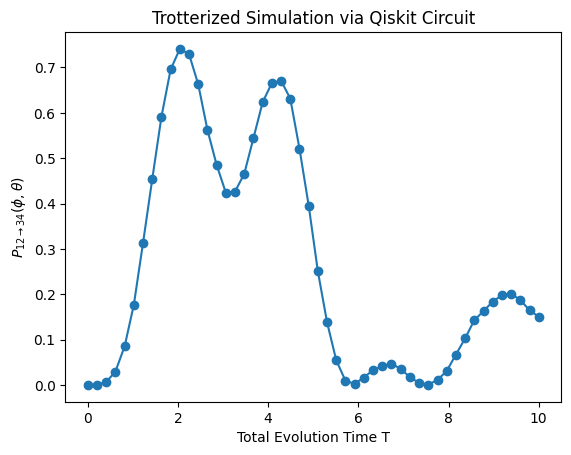

In [2]:
# --------------------------
# Simulation Using Qiskit
# --------------------------
backend = BasicSimulator()
shots = 8192
probs = []

# Our target state is |0011>, meaning (in Qiskit's ordering) q3=0, q2=0, q1=1, q0=1.
target_state = '0011'

for T_total in T_total_values:
    qc = build_trotter_circuit(T_total, trotter_steps)
    compiled_circuit = transpile(qc, backend)
    job = backend.run(compiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts()
    prob = counts.get(target_state, 0) / shots
    probs.append(prob)

plt.plot(T_total_values, probs, 'o-')
plt.xlabel("Total Evolution Time T")
plt.ylabel(r"$P_{12\to34}(\phi,\theta)$")
plt.title("Trotterized Simulation via Qiskit Circuit")
plt.show()

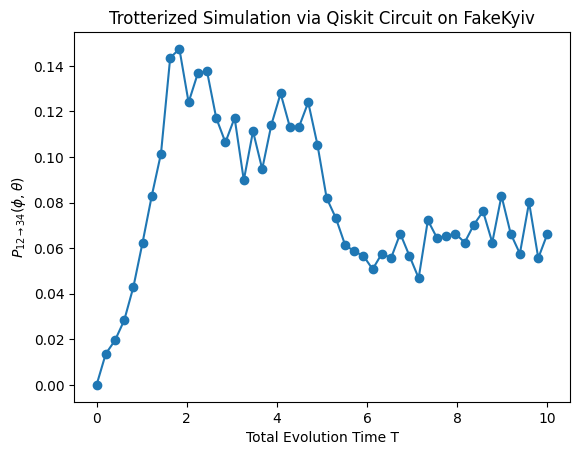

In [3]:
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeKyiv

# --------------------------
# Run on Qiskit IBM Runtime Fake Provider (FakeKyiv)
# --------------------------
backend = FakeKyiv()
sampler = Sampler(mode=backend)
shots = 1024
probs = []

# Our target state is |0011> (in Qiskit's ordering, this means q3=0,q2=0,q1=1,q0=1),
# corresponding to particles in sites 3 and 4.
target_state = '0011'

for T_total in T_total_values:
    qc = build_trotter_circuit(T_total, trotter_steps)
    compiled_circuit = transpile(qc, backend)
    job = sampler.run([compiled_circuit], shots=shots)
    result = job.result()
    counts = result[0].data.c.get_counts()
    prob = counts.get(target_state, 0) / shots
    probs.append(prob)

plt.plot(T_total_values, probs, 'o-')
plt.xlabel("Total Evolution Time T")
plt.ylabel(r"$P_{12\to34}(\phi,\theta)$")
plt.title("Trotterized Simulation via Qiskit Circuit on FakeKyiv")
plt.show()